<img style ="float:right" src = "https://d1vwxdpzbgdqj.cloudfront.net/s3-public-images/learning-partners/greatlearning-brand.svg" width=15%>

# Case Study: Yelp Restaurant Recommendation System

---------------
## Context
---------------

Yelp was founded in 2004 to help people find great local businesses like businesses, hairstylists, etc. Today, the website and their mobile application publish crowd-sourced reviews about local businesses as well as certain metadata about them that can help in customer's decision making process. Yelp uses automated software to recommend the most helpful and reliable reviews for the Yelp community out of such a large and diverse dataset.

The Yelp dataset is a large collection of user reviews, business metadata, business check-ins, users' social network data, user tips for businesses across 10 cities spread across 4 countries. The original dataset is very huge with ~ 11GB of data. In this case study, we will only use a subset of data due to hardware limitations.

-----------------
## Objective
-----------------

In this case study, we will build three types of recommendation systems: 
- **Knowledge/Rank Based recommendation system**
- **Similarity Based Collaborative filtering**
- **Matrix Factorization Based Collaborative Filtering**


-----------------
## Dataset
-----------------

We will only use the following four attributes from the **Restaurant Ratings Data.xlsx**: 
- business_id
- business_name
- stars
- user_id

In [7]:
# uncomment if you are using google colab

#from google.colab import drive
#drive.mount('/content/drive')

### **Importing Libraries**

In [8]:
# installing surprise library, only do it for first time
#!pip install scikit-surprise

In [9]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from surprise import accuracy

# class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# class for loading datasets
from surprise.dataset import Dataset

# for model tuning model hyper-parameters
from surprise.model_selection import GridSearchCV

# for splitting the rating data in train and test dataset
from surprise.model_selection import train_test_split

# for implementing similarity based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# for implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

from collections import defaultdict

# for implementing cross validation
from surprise.model_selection import KFold

### **Loading the data**

In [10]:
data = pd.read_excel('Restaurant Ratings Data.xlsx')

Let's check the **info** of the data

In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 223538 entries, 0 to 223537
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   business_id    223527 non-null  object
 1   business_name  223538 non-null  object
 2   user_id        223538 non-null  object
 3   stars          223538 non-null  int64 
dtypes: int64(1), object(3)
memory usage: 6.8+ MB


- There are **223538 observations** and **4 columns** in the data

### Data Exploration
#### Print top 5 rows of the dataset and describe the dataset.  

In [12]:
#printing the top 5 rows of the dataset
data.head()

,business_id,business_name,user_id,stars
0,9yKzy9PApeiPPOUJEtnvkg,Morning Glory Cafe,rLtl8ZkDX5vH5nAx9C3q5Q,5
1,ZRJwVLyzEJq1VAihDhYiow,Spinato's Pizzeria,0a2KyEL0d3Yb1V6aivbIuQ,5
2,6oRAC4uyJCsJl1X0WZpVSA,Haji-Baba,0hT2KtfLiobPvh6cDC8JQg,4
3,_1QQZuf4zZOyFCvXc0o6Vg,Chaparral Dog Park,uZetl9T0NcROGOyFfughhg,5
4,6ozycU1RpktNG2-1BroVtw,Discount Tire,vYmM4KTsC8ZfQBg-j5MWkw,5


#### Describe the distribution of ratings.

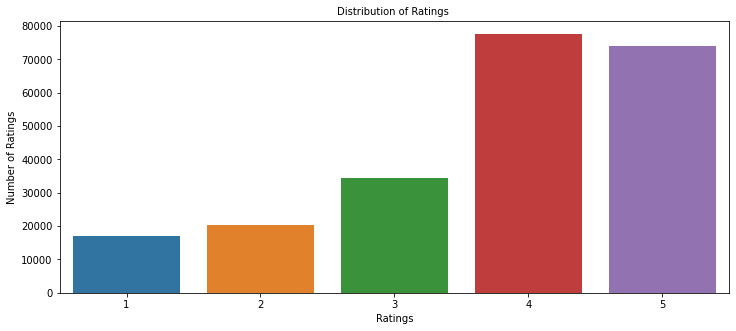

In [13]:
plt.figure(figsize = (12, 5))
ax = sns.countplot(x="stars", data=data)

plt.tick_params(labelsize = 10)
plt.title("Distribution of Ratings ", fontsize = 10)
plt.xlabel("Ratings", fontsize = 10)
plt.ylabel("Number of Ratings", fontsize = 10)
plt.show()

In [14]:
data.stars.value_counts(normalize=True)*100

4    34.742191
5    33.153647
3    15.359357
2     9.128202
1     7.616602
Name: stars, dtype: float64

**Observations:**

* Dataset has about 223527 rows and 4 columns. There are no Nulls in the dataset. The ratings are ranging from 1 to 5.

* Data seems to be highly skewed towards Rating '4' and '5'. Rating '5' is second highest in count and nearly same as number of 4 rating count. 

* We can see very few people are giving rating between 1 to 3. It shows people are tend to not giving a rating for a restaurant which they don't like.

##### What is the total number of unique users and unique Restaurant?

In [15]:
#number of unique users
data['user_id'].nunique()

45066

In [16]:
#number of unique Restaurant 
data['business_id'].nunique()
#Total Rating ~510M

11375

**Observations:**
- There are **45066 users** in the dataset
- There are **11375 Restaurants** in the dataset
- As per the number of unique users and Restaurant, there is a **possibility of 45066 * 11375 = ~51x10^7 ratings** in the dataset. But **we  have 223527 ratings**, i.e. not every user has rated every Restaurant in the dataset. And we can build a recommendation system to recommend restaurant to users which they have not interacted with.

#### Is there any restaurant that has been interacted with more than once by the same user?

In [17]:
data.groupby(['user_id', 'business_id']).count()

business_name  stars
user_id                business_id                                 
--5hzxWLz5ozIg6OMo6tpQ Z3n01OZqARDv06QgBneOZw              1      1
--65q1FpAL_UQtVZ2PTGew 0vzZ_Bcb02rJljeMU9XkBw              1      1
                       18TUn9oiW0k0yB6lheiOvw              1      1
                       1NZLxU5WvB5roPFzneAlLw              1      1
                       1xu5wFd0TeBg6xNBiRtknw              1      1
...                                                      ...    ...
zztT9KKp0rmJRMeMl4CqzQ A8Khz3eeqIFFGaXurg3hxw              1      1
                       ilJiRYZgxjrEu2iexKu-pQ              1      1
                       sbsFamEj5wDxNAjUKrMcSw              1      1
                       wP5849J1DKB2KS3M6UwOAg              1      1
zzunUJtZqhcxDB3plnSFxg kuGQG_8i9P-4p9_Mym-G8Q              1      1

[223526 rows x 2 columns]

In [18]:
data.groupby(['user_id', 'business_id']).count()['stars'].sum()

223527

- The **sum is equal to the total number of observations** which implies that **there is only interaction between a pair of restaurant and a user**.

#### Which restaurant is the most reviewed in the dataset?

In [19]:
data['business_id'].value_counts()

hW0Ne_HTHEAgGF1rAdmR-g    832
VVeogjZya58oiTxK7qUjAQ    784
JokKtdXU7zXHcr20Lrk29A    718
ntN85eu27C04nwyPa8IHtw    671
EWMwV5V9BxNs_U6nNVMeqw    638
                         ... 
n3aU1lbFdHvQ6LIMGd1kRQ      2
sAwxt4I4gTiL-08nyarJbg      2
6JKOKRgtnJWn3KgsgFYaYw      2
3ZXpAvE6KT3oJm1FUvuEVQ      1
2eedL3hDviwReK0w1NkRIw      1
Name: business_id, Length: 11375, dtype: int64

**Observations:**
- The **Restaurant with business_id:hW0Ne_HTHEAgGF1rAdmR-g  has been interacted by most users** which is **832** times.
- But still, there is a possibility of 45066-832 = 44254 more interactions as we have 45066 unique users in our datasets. For those  remaining users, we can build a recommendation system to predict who is most likely to interact with this Restaurant.

Also, out of these 832 interactions, we need to consider the distribution of ratings as well to check whether this Restaurant is the most liked or most disliked Restaurant.

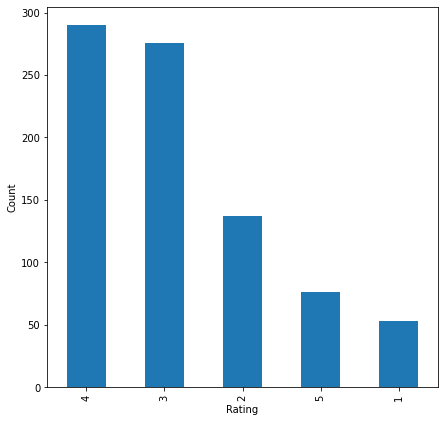

In [20]:
#Plotting distributions of ratings for 832 interactions with given business_id 

plt.figure(figsize=(7,7))

data[data['business_id'] == "hW0Ne_HTHEAgGF1rAdmR-g"]['stars'].value_counts().plot(kind='bar')

plt.xlabel('Rating')

plt.ylabel('Count')

plt.show()

**Observations:**
- We can see that **this Restaurant not liked by the many of users**, as the count of ratings 3 and 4 is higher than the count of other rating.
- There can be Restaurant with very high interactions but the count of ratings 1 and 2 may be much higher than 4 or 5 which would imply that the Restaurant is disliked by the majority of users.

#### Which user interacted the most with any Restaurant in the dataset?

In [69]:
data['user_id'].value_counts()

fczQCSmaWF78toLEmb0Zsw    582
90a6z--_CUrl84aCzZyPsg    499
0CMz8YaO3f8xu4KqQgKb9Q    470
4ozupHULqGyO42s3zNUzOQ    437
joIzw_aUiNvBTuGoytrH7g    386
                         ... 
0UN28H98ypsqziR4OtxpSA      1
ff3NqoaitypL0N7dL-ZITw      1
51c601DXEPbcZ2XmhbGsFg      1
w_Xer9xDkD1vQhKMR8Wi4w      1
dDNfSFT0VApxPmURclX6_g      1
Name: user_id, Length: 45066, dtype: int64

**Observations:**
- The user with **user_id: fczQCSmaWF78toLEmb0Zsw** has interacted with the most number of Restaurant i.e. **582** times. 
- But still, there is a possibility of 11375-520 =  10855 more interactions as we have 11375 unique Restaurants in our dataset. For those **10855** remaining Restaurants, we can build a recommendation system to predict which Restaurant are most likely to be reviews by this user.

**As this dataset is very large and has 223538 observations, it is not computationally possible to build a model using this.Moreover, there are many users who have only rated a few restaurants and also there are products which are rated by very less users. Hence we can reduce the dataset by considering certain Logical assumption.**

Here, We will be taking users who have given at least 50 rating, as we prefer to have some number of rating of a restaurant and the restaurant who has at least 10 rating, as when we shop online we prefer to have some number of rating of a restaurant. . 

###### You can run Recommendation System Algorithm such as ALS (similar to SVD approach) on a large dataset using Spark ML Lib library
<br>
Link for reference -<br>
https://towardsdatascience.com/build-recommendation-system-with-pyspark-using-alternating-least-squares-als-matrix-factorisation-ebe1ad2e7679

In [21]:
data.shape

(223538, 4)

In [23]:
# Get the column containing the users
users = data.user_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1   

In [24]:
# We want our users to have at least 50 ratings to be considred
RATINGS_CUTOFF = 50
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

In [26]:
len(remove_users)

44412

In [27]:
remove_users[:5]

['0a2KyEL0d3Yb1V6aivbIuQ',
 '0hT2KtfLiobPvh6cDC8JQg',
 'uZetl9T0NcROGOyFfughhg',
 'vYmM4KTsC8ZfQBg-j5MWkw',
 '1ieuYcKS7zeAv_U15AB13A']

In [28]:
data = data.loc[~data.user_id.isin(remove_users)]

In [29]:
data.shape

(65387, 4)

In [38]:
# Get the column containing the users
users = data.business_id
# Create a dictionary from users to their number of ratings
ratings_count = dict()
for user in users:
    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1
    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1 

In [39]:
len(ratings_count)

8996

In [40]:
# We want our item to have at least 10 ratings to be considred
RATINGS_CUTOFF = 10
remove_users = []
for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

In [41]:
remove_users[:5]

['WGNIYMeXPyoWav1APUq7jA',
 '4JzzbSbK9wmlOBJZWYfuCg',
 'faSdsW2s_SaVN0KTy-R2MQ',
 'pRmHreZcF7YmNEEPukfcFg',
 'd7_jkx0VPx3uHsUl18iHMQ']

In [42]:
rating = data.loc[~data.business_id.isin(remove_users)]

In [43]:
data.shape

(65387, 4)

#### What is the distribution of the user-Restaurant interactions in this dataset?

In [44]:
data.nunique()
# 8995 restaurants recommended by 654 users

business_id      8995
business_name    6328
user_id           654
stars               5
dtype: int64

In [47]:
#Finding user-Restaurant interactions distribution

count_interactions = data.groupby('user_id').count()['business_id'].sort_values(ascending=False)
count_interactions
#Restaurant Interactions per User

user_id
fczQCSmaWF78toLEmb0Zsw    582
90a6z--_CUrl84aCzZyPsg    499
0CMz8YaO3f8xu4KqQgKb9Q    470
4ozupHULqGyO42s3zNUzOQ    437
joIzw_aUiNvBTuGoytrH7g    386
                         ... 
Zm08wcep2F-nRTHRyR8mpw     50
b87-U2ZwReh80dLWA-ZieA     50
gv6GLZ3-bgSs44PtPJR1Bg     50
PDRWbCZa92irf8mK5X_Kig     50
8-InERGLhHGjX3DZPFXMqg     50
Name: business_id, Length: 654, dtype: int64

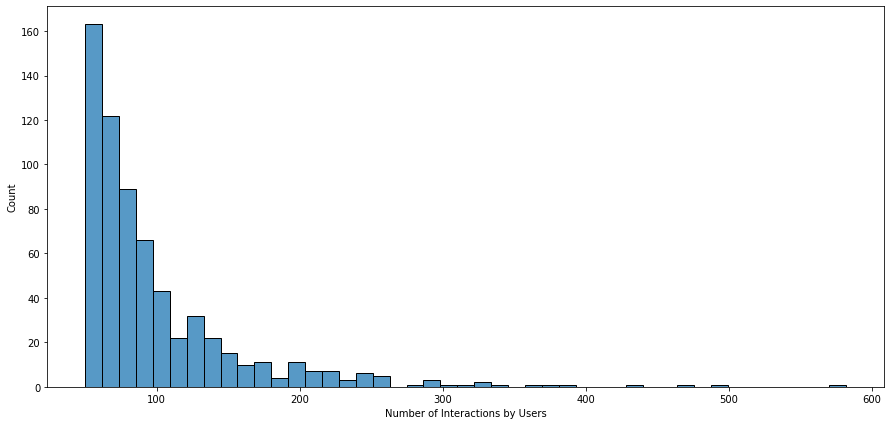

In [48]:
#Plotting user-item interactions distribution

plt.figure(figsize=(15,7))

sns.histplot(count_interactions)

plt.xlabel('Number of Interactions by Users')

plt.show()
#What think about distribution ? 

In [ ]:
#Very few restaurants with large number of reviews by users - Long Tail dist. 

- It is very skewed
- It clearly shows that there are very few Restaurant which has many ratings.

#### As we have now explored the data, let's start building Recommendation systems

### Model 1: Create Rank-Based Recommendation System (Population Avg)

Rank-based recommendation systems provide recommendations based on the most popular items. This kind of recommendation system is useful when we have **cold start** problems. Cold start refers to the issue when we get a new user into the system and the machine is not able to recommend Restaurant to the new user, as the user did not have any historical interactions in the dataset. In those cases, we can use rank-based recommendation system to recommend Restaurant to the new user.

To build the rank-based recommendation system, we take **average** of all the ratings provided to each Restaurant and then rank them based on their average rating.

In [49]:
#Calculating average ratings by business
average_rating = data.groupby('business_id').mean()['stars']

In [51]:
average_rating[:3]

business_id
--5jkZ3-nUPZxUvtcbr8Uw    5.000000
-0D_CYhlD2ILkmLR0pBmnA    5.000000
-0QBrNvhrPQCaeo7mTo0zQ    4.333333
Name: stars, dtype: float64

In [52]:
#Calculating the count of ratings
count_rating = data.groupby('business_id').count()['stars']

In [53]:
count_rating[:3]

business_id
--5jkZ3-nUPZxUvtcbr8Uw    2
-0D_CYhlD2ILkmLR0pBmnA    1
-0QBrNvhrPQCaeo7mTo0zQ    3
Name: stars, dtype: int64

In [54]:
#Making a dataframe with the count and average of ratings
final_rating = pd.DataFrame({'avg_rating':average_rating, 'rating_count':count_rating})

In [55]:
final_rating.head()

,avg_rating,rating_count
business_id,,
--5jkZ3-nUPZxUvtcbr8Uw,5.000000,2
-0D_CYhlD2ILkmLR0pBmnA,5.000000,1
-0QBrNvhrPQCaeo7mTo0zQ,4.333333,3
-0bUDim5OGuv8R0Qqq6J4A,4.000000,1
-0xwm_AwS0d_5rwUprHGuw,3.428571,7


Now, let's create a function to find the **top n Restaurant** for a recommendation based on the average ratings of Restaurant. We can also add a **threshold for a minimum number of interactions** for a Restaurant to be considered for recommendation. 

In [56]:
def top_n_Restaurant(data, n, min_interaction=100):
    
    #Finding restautants with minimum number of interactions
    recommendations = data[data['rating_count'] > min_interaction]
    
    #Sorting values w.r.t average rating 
    recommendations = recommendations.sort_values(by='avg_rating', ascending=False)
    
    return recommendations.index[:n]

We can **use this function with different n's and minimum interactions** to get Restaurant to recommend

##### Recommending top 5 Restaurant with 50 minimum interactions based on popularity

In [58]:
# Global Number -> across Population and not customize to every user
list(top_n_Restaurant(final_rating, 5, 50))

['xHI3saK0sAJEHeMK4IGVvg',
 'Bc4DoKgrKCtCuN-0O5He3A',
 '6rijZ1qIjiq1Dgdy35iqxw',
 'u0NbikWwP7TVkMkCily-4g',
 'qMkIbQFrROSnPaQ7at85-w']

#### Now that we have seen how to apply the Rank-Based Recommendation System, let's apply Collaborative Filtering Based Recommendation System

### Model 2: Collaborative Filtering Based Recommendation System

In this type of recommendation system, `we do not need any information` about the users or items. We only need user item interaction data to build a collaborative recommendation system. For example - 
<ol>
    <li><b>Ratings</b> provided by users. For example - ratings of books on goodread, movie ratings on imdb etc</li>
    <li><b>Likes</b> of users on different facebook posts, likes on youtube videos</li>
    <li><b>Use/buying</b> of a product by users. For example - buying different items on e-commerce sites</li>
    <li><b>Reading</b> of articles by readers on various blogs</li>
</ol>

#### Types of Collaborative Filtering

- Similarity/Neighborhood based
- Model based

Below we are building similarity based recommendation system using `cosine` similarity and using KNN to find similar users which are nearest neighbor to the given user. 

We will be using a new library - `surprise` to build the remaining models, let's first import the necessary classes and functions from this library

#### Let's encode the user_id and business_id for simplicity, also encoding them will not make any change in the prediction. 

In [59]:
from sklearn.preprocessing import LabelEncoder
df=data[['user_id','business_id']].apply(LabelEncoder().fit_transform)
df['rating']=data['stars']
df.head()

,user_id,business_id,rating
0,568,1476,5
5,620,8973,5
10,311,6352,5
11,343,4694,4
14,291,8026,3


In [60]:
data.head(5)
#Map business id 9yKzy9PApeiPPOUJEtnvkg -> 1476 & user id rLtl8ZkDX5vH5nAx9C3q5Q to 568

,business_id,business_name,user_id,stars
0,9yKzy9PApeiPPOUJEtnvkg,Morning Glory Cafe,rLtl8ZkDX5vH5nAx9C3q5Q,5
5,zp713qNhx8d9KCJJnrw1xA,La Condesa Gourmet Taco Shop,wFweIWhv2fREZV_dYkz_1g,5
10,h53YuCiIDfEFSJCQpk8v1g,Jason's Deli,UPtysDF6cUDUxq2KY-6Dcg,5
11,WGNIYMeXPyoWav1APUq7jA,The Lady Luck Tattoo Gallery,Xm8HXE1JHqscXe5BKf0GFQ,4
14,supigcPNO9IKo6olaTNV-g,1130 The Restaurant,SBbftLzfYYKItOMFwOTIJg,3


Below we are loading the `data` dataset, which is a pandas dataframe, into a different format called `surprise.dataset.DatasetAutoFolds` which is required by this library. To do this we will be using the classes `Reader` and `Dataset`

#### Making the dataset into surprise dataset and splitting it into train and test set

In [61]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))



In [62]:
reader

In [63]:
# loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'business_id', 'rating']], reader)

In [64]:
data

In [65]:
# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.3, random_state=42)

### Now we are ready to build the first baseline similarity based recommendation system using cosine similarity and KNN

We will use KNNBasic and add parameter **'cosine'**

In [68]:
# User User KNN Recommendation System
sim_options = {'name': 'cosine',
               'user_based': True}

algo_knn_user = KNNBasic(sim_options=sim_options,verbose=False)

In [69]:
# Train the algorithm on the trainset, and predict ratings for the testset
algo_knn_user.fit(trainset)
predictions = algo_knn_user.test(testset)

In [70]:
# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0516


1.0515902715343899

#### What is the RMSE for baseline user based collaborative filtering recommendation system?

- As we can see from above, these baseline model has `RMSE=1.05` on test set, we will try to improve this number later by using `GridSearchCV` tuning different hyperparameters of this algorithm


#### What is the Predicted  rating for an user with userId=1 and for business_id= 126 and business_id=2150?

In [71]:
algo_knn_user.predict(1,126, r_ui=4, verbose=True)

user: 1          item: 126        r_ui = 4.00   est = 3.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=1, iid=126, r_ui=4, est=3.0, details={'actual_k': 1, 'was_impossible': False})

- As we can see - the actual rating for this user-item pair is 4 and predicted rating is 3 by this similarity based baseline model

Let's predict the rating for the same `userId=1` but for a restaurant which this user has not a rated before i.e. `business_id=2150`

In [72]:
algo_knn_user.predict(1,2150, verbose=True)

user: 1          item: 2150       r_ui = None   est = 4.67   {'actual_k': 9, 'was_impossible': False}


Prediction(uid=1, iid=2150, r_ui=None, est=4.665900876518288, details={'actual_k': 9, 'was_impossible': False})

- As we can see the estimated rating for this user-item pair is 4.67 based on this similarity based baseline model

### Improving similarity based recommendation system by tuning its hyper-parameters

Below we will be tuning hyper-parmeters for the `KNNBasic` algorithms. Let's try to understand different hyperparameters of KNNBasic algorithm - 

- **k** (int) – The (max) number of neighbors to take into account for aggregation (see this note). Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise - 
    - cosine
    - msd (default)
    - pearson
    - pearson baseline
    
For more details please refer the official documentation https://surprise.readthedocs.io/en/stable/knn_inspired.html

#### Perform hyperparameter tuning for the baseline user based collaborative filtering recommendation system and find the RMSE for tuned user based collaborative filtering recommendation system?

In [73]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30, 40], 'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [True]}
              }

# performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

#TR1 TR2 Test3
#TR1 Test2 TR3
#Test1 TR2 TR3

In [74]:
# fitting the data
gs.fit(data)

In [75]:
# best RMSE score
print(gs.best_score['rmse'])

1.0295331701416497


In [76]:
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

{'k': 40, 'min_k': 3, 'sim_options': {'name': 'cosine', 'user_based': True}}


Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [79]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head(3)
#For every split, calculate rmse and mae
#Further calculatre mean and std for rmse and mae combining all splits

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,1.023359,1.031801,1.043270,1.032810,0.008160,12,0.803504,0.805660,0.816215,0.808460,0.005554,5,0.086665,0.003091,1.005998,0.019097,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': True}"
1,1.022793,1.030606,1.040820,1.031406,0.007381,7,0.804049,0.805971,0.815399,0.808473,0.004960,6,0.417330,0.020679,1.089668,0.050770,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': True}"
2,1.024918,1.029942,1.041229,1.032030,0.006820,11,0.808452,0.808793,0.817445,0.811564,0.004161,11,0.074666,0.008732,1.044665,0.034837,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': True}"


In [78]:
results_df.shape
# 3*3*2

(18, 20)

Now we will building final model by using tuned values of the hyperparameters which we received by using grid search cross validation

In [80]:
# using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine',
               'user_based': True}

# creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized = KNNBasic(sim_options=sim_options, k=40, min_k=3,Verbose=False)


In [81]:
# training the algorithm on the trainset
similarity_algo_optimized.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [82]:
# predicting ratings for the testset
predictions = similarity_algo_optimized.test(testset)

In [83]:
# computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 1.0331


1.033112241295183

- We can see from above that after tuning hyperparameters, RMSE for testset has reduced to 1.05 from 1.03. We can say that we have been able to improve the model after hyperparameter tuning

#### What is the Predicted  rating for an user with userId=1 and for business_id= 126 and business_id=2150 using tuned user based collaborative filtering?

#### Let's us now predict rating for an user with `userId=1` and for `business_id=126` with the optimized model

In [84]:
similarity_algo_optimized.predict(1,126, r_ui=4, verbose=True)

user: 1          item: 126        r_ui = 4.00   est = 3.72   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=1, iid=126, r_ui=4, est=3.723661787196854, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- If we compare the above predicted rating, we can see the baseline model predicted rating as `3.0` and the optimized model predicted the rating as `3.72`. whereas the actual rating is `4`, i.e. predicted rating from the optimized model is closer to the actual rating.

Below we are predicting rating for the same `userId=1` but for a restaurant which this user has not a rated before i.e. `business_id=2150`, by using the optimized model as shown below

In [85]:
similarity_algo_optimized.predict(1,2150, verbose=True)

user: 1          item: 2150       r_ui = None   est = 4.67   {'actual_k': 9, 'was_impossible': False}


Prediction(uid=1, iid=2150, r_ui=None, est=4.665900876518288, details={'actual_k': 9, 'was_impossible': False})

- If we compare the above predicted rating, we can see the baseline model predicted rating as `4.67` and the optimized model predicted the rating as `4.68`.

#### Identifying similar users to a given user (nearest neighbors)

We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=1` based on the `msd` distance metric

In [86]:
similarity_algo_optimized.get_neighbors(1, k=5)

[4, 5, 6, 8, 12]

#### Implementing the recommendation algorithm based on optimized KNNBasic model

Below we will be implementing a function where the input parameters are - 

- data: a rating dataset
- user_id: an user id against which we want the recommendations
- top_n: the number of items we want to recommend
- algo: the algorithm we want to use to predict the ratings

In [87]:
def get_recommendations(data, user_id, top_n, algo):
    
    # creating an empty list to store the recommended business ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='business_id', values='rating')
    
    # extracting those business ids which the user_id has not interacted yet
    non_interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()
    
    # looping through each of the business id which user_id has not interacted yet
    for business_id in non_interacted_items:
        
        # predicting the ratings for those non interacted business ids by this user
        est = algo.predict(user_id, business_id).est
        
        # appending the predicted ratings
        recommendations.append((business_id, est))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return recommendations[:top_n] # returing top n highest predicted rating items for this user

In [88]:
df=df.drop_duplicates()

#### Predict the top 5 items for userId=1 with similarity based recommendation system

In [91]:
recommendations = get_recommendations(df, 1, 15, similarity_algo_optimized)

In [92]:
recommendations

[(234, 5),
 (242, 5),
 (248, 5),
 (372, 5),
 (545, 5),
 (557, 5),
 (723, 5),
 (754, 5),
 (772, 5),
 (1120, 5),
 (1181, 5),
 (1242, 5),
 (1324, 5),
 (1577, 5),
 (1582, 5)]

### Model 3: Item based Collaborative Filtering Recommendation System

In [93]:
#Item Item Collaborative Filtering

#defing similarity measure
sim_options = {'name': 'cosine',
               'user_based': False}

#defining Nearest neighbour algorithm
algo_knn_item = KNNBasic(sim_options=sim_options,verbose=False)

# Train the algorithm on the trainset or fitting the model on train dataset 
algo_knn_item.fit(trainset)

#predict ratings for the testset
predictions = algo_knn_item.test(testset)

# Then compute RMSE
accuracy.rmse(predictions)

RMSE: 1.0660


1.0659549417441987

#### What is the RMSE for baseline item based collaborative filtering recommendation system ?

- As we can see from above, these baseline model has `RMSE=1.06` on test set, we will try to improve this number later by using `GridSearchCV` tuning different hyperparameters of this algorithm

#### What is the Predicted  rating for an user with userId=1 and for business_id= 126 and business_id=2150 using tuned user based collaborative filtering?

In [94]:
algo_knn_item.predict(1, 126, r_ui=4, verbose=True)

user: 1          item: 126        r_ui = 4.00   est = 5.00   {'actual_k': 1, 'was_impossible': False}


Prediction(uid=1, iid=126, r_ui=4, est=5, details={'actual_k': 1, 'was_impossible': False})

- As we can see - the actual rating for this user-item pair is 4 and predicted rating is 5 by this similarity based baseline model

Let's predict the rating for the same `userId=1` but for a restaurant which this user has not a rated before i.e. `business_id=2150`

In [95]:
algo_knn_item.predict(1, 2150, verbose=True)

user: 1          item: 2150       r_ui = None   est = 4.09   {'actual_k': 11, 'was_impossible': False}


Prediction(uid=1, iid=2150, r_ui=None, est=4.090766231317369, details={'actual_k': 11, 'was_impossible': False})

- As we can see the estimated rating for this user-item pair is 4.09 based on this similarity based baseline model

#### Perform hyperparameter tuning for the baseline item based collaborative filtering recommendation system and find the RMSE for tuned item based collaborative filtering recommendation system?

In [96]:
# setting up parameter grid to tune the hyperparameters
param_grid = {'k': [20, 30], 'min_k': [3,6,9],
              'sim_options': {'name': ['msd', 'cosine'],
                              'user_based': [False]}
              }

# performing 3-fold cross validation to tune the hyperparameters
grid_obj = GridSearchCV(KNNBasic, param_grid, measures=['rmse', 'mae'], cv=3)

# fitting the data
grid_obj.fit(data)

# best RMSE score
print(grid_obj.best_score['rmse'])

# combination of parameters that gave the best RMSE score
print(grid_obj.best_params['rmse'])

Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above:

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [97]:
results_df = pd.DataFrame.from_dict(grid_obj.cv_results)
results_df.head(3)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_k,param_min_k,param_sim_options
0,1.048094,1.043841,1.046381,1.046105,0.001747,6,0.817285,0.815580,0.813758,0.815541,0.001440,6,1.196658,0.062469,1.460706,0.048635,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'msd', 'user_based': False}"
1,1.062069,1.058436,1.058374,1.059627,0.001727,12,0.831778,0.831176,0.828359,0.830438,0.001491,12,3.230612,0.438613,1.752412,0.198525,"{'k': 20, 'min_k': 3, 'sim_options': {'name': ...",20,3,"{'name': 'cosine', 'user_based': False}"
2,1.043761,1.037859,1.039708,1.040442,0.002465,4,0.815830,0.814032,0.810851,0.813571,0.002059,3,1.360668,0.080549,1.809117,0.251106,"{'k': 20, 'min_k': 6, 'sim_options': {'name': ...",20,6,"{'name': 'msd', 'user_based': False}"


In [98]:
results_df.shape #2*3*2

(12, 20)

In [99]:
# creating an instance of KNNBasic with optimal hyperparameter values
similarity_algo_optimized_item = KNNBasic(sim_options={'name': 'msd', 'user_based': False}
                                          , k=30, min_k=9,verbose=False)

# training the algorithm on the trainset
similarity_algo_optimized_item.fit(trainset)


In [100]:
# predicting ratings for the testset
predictions = similarity_algo_optimized_item.test(testset)

In [101]:
# computing RMSE on testset
accuracy.rmse(predictions)

RMSE: 1.0364


1.0364317827193754

- We can see from above that after tuning hyperparameters, RMSE for testset has reduced to 1.06 from 1.03. The model has been improved slightly.

#### What is the Predicted  rating for an user with userId=1 and for business_id=126 and business_id=2150 using tuned item based collaborative filtering?

In [102]:
similarity_algo_optimized_item.predict(1, 126, r_ui=4, verbose=True)

user: 1          item: 126        r_ui = 4.00   est = 3.72   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid=1, iid=126, r_ui=4, est=3.723661787196854, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

- If we compare the above predicted rating, we can see the baseline model predicted rating as `5` and the optimized model predicted the rating as `3.72`. whereas the actual rating is `4`, i.e. predicted rating from the optimized model is closer to the actual rating.

Let's predict the rating for the same `userId=1` but for a restaurant which this user has not a rated before i.e. `business_id=2150`

In [103]:
similarity_algo_optimized_item.predict(1,2150, verbose=True)

user: 1          item: 2150       r_ui = None   est = 3.95   {'actual_k': 11, 'was_impossible': False}


Prediction(uid=1, iid=2150, r_ui=None, est=3.950186799501868, details={'actual_k': 11, 'was_impossible': False})

- If we compare the above predicted rating, we can see the baseline model predicted rating as `4.09` and the optimized model predicted the rating as `3.95`.

#### Identifying similar users to a given user (nearest neighbors)
We can also find out the similar users to a given user or its nearest neighbors based on this KNNBasic algorithm. Below we are finding 5 most similar user to the `userId=1` based on the `msd` distance metric

In [104]:
similarity_algo_optimized_item.get_neighbors(1, k=5)

[21, 186, 203, 204, 240]

#### Predicted top 5 restaurants for userId=1 with similarity based recommendation system

In [105]:
recommendations = get_recommendations(df, 1, 5, similarity_algo_optimized_item)

In [106]:
recommendations

[(876, 4.565656565656565),
 (7416, 4.479041916167665),
 (4800, 4.468850036936716),
 (6545, 4.449059903804111),
 (8109, 4.429126213592233)]

### Model 4: Based Collaborative Filtering - Matrix Factorization using SVD

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

**Latent Features:** The features that are not present in the empirical data but can be inferred from the data.

### Build a baseline matrix factorization recommendation system

In [107]:
# using SVD matrix factorization
algo_svd = SVD()


In [108]:
# training the algorithm on the trainset
algo_svd.fit(trainset)

In [109]:
# predicting ratings for the testset
predictions = algo_svd.test(testset)

In [110]:
# computing RMSE on the testset
accuracy.rmse(predictions)

RMSE: 0.9891


0.9891417247899124

#### What is the RMSE for baseline SVD based collaborative filtering recommendation system

- We can that the baseline RMSE for matrix factorization model on testset (which is `0.98`) is lower as compared to the RMSE for baseline similarity based recommendation system (which is `1.06`) and it is even lesser than the RMSE for optimized similarity based recommendation system (which is `1.03`)

#### What is the Predicted  rating for an user with userId=1 and for business_id= 126 and business_id=2150 ?

In [111]:
algo_svd.predict(1,126, r_ui=4, verbose=True)

user: 1          item: 126        r_ui = 4.00   est = 3.63   {'was_impossible': False}


Prediction(uid=1, iid=126, r_ui=4, est=3.634835487861103, details={'was_impossible': False})

- As we can see - the actual rating for this user-item pair is 4 and predicted rating is 3.80 by this matrix factorization based baseline model. It seems like we have over estimated the rating by a small margin. We will try to fix this later by tuning the hyperparameters of the model using GridSearchCV

Let's predict the rating for the same `userId=1` but for a restaurant which this user has not a rated before i.e. `business_id=2150`

In [112]:
algo_svd.predict(1,2150,verbose=True)

user: 1          item: 2150       r_ui = None   est = 4.41   {'was_impossible': False}


Prediction(uid=1, iid=2150, r_ui=None, est=4.4107549016923695, details={'was_impossible': False})

- We can see that estimated rating for this user-item pair is 4.33 based on this matrix factorization based baseline model

#### Improving matrix factorization based recommendation system by tuning its hyper-parameters

In SVD, rating is predicted as - 

$$\hat{r}_{u i}=\mu+b_{u}+b_{i}+q_{i}^{T} p_{u}$$

If user $u$ is unknown, then the bias $b_{u}$ and the factors $p_{u}$ are assumed to be zero. The same applies for item $i$ with $b_{i}$ and $q_{i}$.

To estimate all the unknown, we minimize the following regularized squared error:

$$\sum_{r_{u i} \in R_{\text {train }}}\left(r_{u i}-\hat{r}_{u i}\right)^{2}+\lambda\left(b_{i}^{2}+b_{u}^{2}+\left\|q_{i}\right\|^{2}+\left\|p_{u}\right\|^{2}\right)$$

The minimization is performed by a very straightforward **stochastic gradient descent**:

$$\begin{aligned} b_{u} & \leftarrow b_{u}+\gamma\left(e_{u i}-\lambda b_{u}\right) \\ b_{i} & \leftarrow b_{i}+\gamma\left(e_{u i}-\lambda b_{i}\right) \\ p_{u} & \leftarrow p_{u}+\gamma\left(e_{u i} \cdot q_{i}-\lambda p_{u}\right) \\ q_{i} & \leftarrow q_{i}+\gamma\left(e_{u i} \cdot p_{u}-\lambda q_{i}\right) \end{aligned}$$

There are many hyperparameters to tune in this algorithm, you can find a full list of hyperparameters [here](https://surprise.readthedocs.io/en/stable/matrix_factorization.html#surprise.prediction_algorithms.matrix_factorization.SVD)

Below we will be tuning only three hyperparameters -
- **n_epochs**: The number of iteration of the SGD algorithm
- **lr_all**: The learning rate for all parameters
- **reg_all**: The regularization term for all parameters

####  Perform hyperparameter tuning for the baseline SVD based collaborative filtering recommendation system and find the RMSE for tuned SVD based collaborative filtering recommendation system?

In [113]:
# set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# performing 3-fold gridsearch cross validation
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=3, n_jobs=-1)

#Search across 27 parameters

In [114]:
# fitting data
gs.fit(data)

In [115]:
# best RMSE score
print(gs.best_score['rmse'])

0.9732433296848911


In [116]:
# combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

{'n_epochs': 30, 'lr_all': 0.01, 'reg_all': 0.2}


Once the grid search is complete, we can get the optimal values for each of those hyperparameters as shown above

Below we are analysing evaluation metrics - RMSE and MAE at each and every split to analyze the impact of each value of hyperparameters

In [119]:
results_df = pd.DataFrame.from_dict(gs.cv_results)
results_df.head(3)

,split0_test_rmse,split1_test_rmse,split2_test_rmse,mean_test_rmse,std_test_rmse,rank_test_rmse,split0_test_mae,split1_test_mae,split2_test_mae,mean_test_mae,std_test_mae,rank_test_mae,mean_fit_time,std_fit_time,mean_test_time,std_test_time,params,param_n_epochs,param_lr_all,param_reg_all
0,1.023324,1.021537,1.020707,1.021856,0.001092,25,0.809791,0.808887,0.806819,0.808499,0.001244,25,2.127332,0.044343,0.258999,0.016871,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.2}",10,0.001,0.2
1,1.022717,1.022424,1.020833,1.021991,0.000828,26,0.810181,0.810424,0.807635,0.809413,0.001261,26,2.138333,0.033994,0.257001,0.011046,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.4}",10,0.001,0.4
2,1.024134,1.023460,1.021296,1.022963,0.001210,27,0.812113,0.811567,0.809214,0.810964,0.001258,27,2.240000,0.035281,0.272332,0.039532,"{'n_epochs': 10, 'lr_all': 0.001, 'reg_all': 0.6}",10,0.001,0.6


In [118]:
results_df.shape

(27, 20)

Now we will building final model by using tuned values of the hyperparameters which we received by using grid search cross validation

In [120]:
# building the optimized SVD model using optimal hyperparameter search
svd_algo_optimized = SVD(n_epochs=30, lr_all=0.01, reg_all=0.2)

# training the algorithm on the trainset
svd_algo_optimized.fit(trainset)

# predicting ratings for the testset
predictions = svd_algo_optimized.test(testset)

# computing RMSE
accuracy.rmse(predictions)

RMSE: 0.9744


0.9743794650305224

#### What is the Predicted  rating for an user with userId=1 and for business_id= 126 and business_id=2150 using SVD based collaborative filtering?

In [121]:
svd_algo_optimized.predict(1,126, r_ui=4, verbose=True)

user: 1          item: 126        r_ui = 4.00   est = 3.52   {'was_impossible': False}


Prediction(uid=1, iid=126, r_ui=4, est=3.5233687739975275, details={'was_impossible': False})

- we can see the optimized model predicted rating as `3.60` whereas the actual rating is `4`.

Let's predict the rating for the same `userId=1` but for a restaurant which this user has not a rated before i.e. `business_id=2150`

In [122]:
svd_algo_optimized.predict(1,2150, verbose=True)

user: 1          item: 2150       r_ui = None   est = 4.56   {'was_impossible': False}


Prediction(uid=1, iid=2150, r_ui=None, est=4.55783460258989, details={'was_impossible': False})

- we can see the optimized model predicted rating as `4.52` 

#### Predict the top 5 restaurants for userId=4 with SVD based recommendation system 

In [123]:
get_recommendations(df,4, 5, svd_algo_optimized)

[(5549, 5),
 (6419, 5),
 (7109, 5),
 (1181, 4.992847788494214),
 (3986, 4.947918942484986)]

### Predicting ratings for already interacted restaurant

Below we are comparing the rating predictions of users for those restaurant which has been already watched by an user. This will help us to understand how well are predictions are as compared to the actual ratings provided by users

In [132]:
def predict_already_interacted_ratings(data, user_id, algo):
    
    # creating an empty list to store the recommended business ids
    recommendations = []
    
    # creating an user item interactions matrix 
    user_item_interactions_matrix = data.pivot(index='user_id', columns='business_id', values='rating')
    
    # extracting those business ids which the user_id has interacted already
    interacted_items = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].notnull()].index.tolist()
    
    # looping through each of the business id which user_id has interacted already
    for business_id in interacted_items:
        
        # extracting actual ratings
        actual_rating = user_item_interactions_matrix.loc[user_id, business_id]
        
        # predicting the ratings for those non interacted item ids by this user
        predicted_rating = algo.predict(user_id, business_id).est
        
        # appending the predicted ratings
        recommendations.append((business_id, actual_rating, predicted_rating))

    # sorting the predicted ratings in descending order
    recommendations.sort(key=lambda x: x[1], reverse=True)

    return pd.DataFrame(recommendations, columns=['business_id', 'actual_rating', 'predicted_rating']) # returing top n highest predicted rating items for this user

Here we are comparing the predicted ratings by `similarity based recommendation` system against actual ratings for `userId=100`

In [135]:
predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df,7,similarity_algo_optimized)
predicted_ratings_for_interacted_items.head(3)

,business_id,actual_rating,predicted_rating
0,214,5.0,3.899854
1,524,5.0,3.723662
2,569,5.0,4.225144


In [136]:
data = predicted_ratings_for_interacted_items.melt(id_vars='business_id', value_vars=['actual_rating', 'predicted_rating'])
data.head(3)
#Columns to Rows

,business_id,variable,value
0,214,actual_rating,5.0
1,524,actual_rating,5.0
2,569,actual_rating,5.0


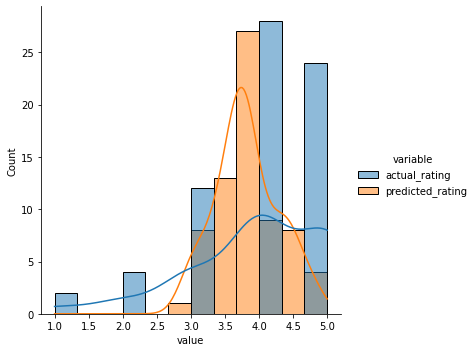

In [137]:
sns.displot(data=data, x='value', hue='variable', kde=True);

- We can see that distribution of predicted ratings is closely following the distribution of actual ratings. The total bins for predicted ratings is higher as compared to total bins for actual ratings.
- This is expected, as actual ratings always have discreet values like 1, 2, 3, 4, 5, but predicted ratings can have continuous values as we are taking aggregated ratings from the nearest neighbors of a given user. But over the predictions looks good as compared to the distribution of actual ratings.

**Below we are comparing the predicted ratings by `matrix factorization based recommendation` system against actual ratings for `user_id=4`**

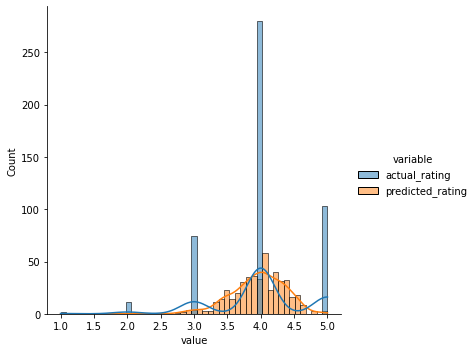

In [138]:
predicted_ratings_for_interacted_items = predict_already_interacted_ratings(df,4, svd_algo_optimized)
data = predicted_ratings_for_interacted_items.melt(id_vars='business_id', value_vars=['actual_rating', 'predicted_rating'])
sns.displot(data=data, x='value', hue='variable', kde=True);

In [139]:
# instantiating Reader scale with expected rating scale
reader = Reader(rating_scale=(0, 5))

# loading the rating dataset
data = Dataset.load_from_df(df[['user_id', 'business_id', 'rating']], reader)

# splitting the data into train and test dataset
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

## Precision and Recall @ k

RMSE is not the only metric we can use here. We can also examine two fundamental measures, precision and recall. We also add a parameter k which is helpful in understanding problems with multiple rating outputs.

See the Precision and Recall @ k section of your notebook and follow the instructions to compute various precision/recall values at various values of k.

To know more about precision recall in Recommendation systems refer to these links : 

https://surprise.readthedocs.io/en/stable/FAQ.html

https://medium.com/@m_n_malaeb/recall-and-precision-at-k-for-recommender-systems-618483226c54

In [148]:
from collections import defaultdict
#function can be found on surprise documentation FAQs
def precision_recall_at_k(predictions, k=10, threshold=3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user.
    user_est_true = defaultdict(list)
    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key=lambda x: x[0], reverse=True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings) #Actual like

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])  #Recommended like

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])   #Overlap

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. We here set it to 0.

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. We here set it to 0.

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    return precisions, recalls

In [149]:
# Make list of k values
#A basic cross-validation iterator.
from surprise.model_selection import KFold
kf = KFold(n_splits=5)
K = [5, 10]   # Top 5 recommendations and Top 10 recommendations

# Make list of models
models = [algo_knn_user, similarity_algo_optimized,algo_knn_item,similarity_algo_optimized_item,
          algo_svd, svd_algo_optimized]

for k in K:
    for model in models:
        print('> k={}, model={}'.format(k,model.__class__.__name__))
        p = []
        r = []
        for trainset, testset in kf.split(data):
            model.fit(trainset)
            predictions = model.test(testset, verbose=False)
            precisions, recalls = precision_recall_at_k(predictions, k=k, threshold=3.5)

            # Precision and recall can then be averaged over all users
            p.append(sum(prec for prec in precisions.values()) / len(precisions))
            r.append(sum(rec for rec in recalls.values()) / len(recalls))
        print('-----> Precision: ', round(sum(p) / len(p), 3))
        print('-----> Recall: ', round(sum(r) / len(r), 3))

> k=5, model=KNNBasic
-----> Precision:  0.791
-----> Recall:  0.39
> k=5, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
-----> Precision:  0.789
-----> Recall:  0.388
> k=5, model=KNNBasic
-----> Precision:  0.652
-----> Recall:  0.308
> k=5, model=KNNBasic
-----> Precision:  0.703
-----> Recall:  0.337
> k=5, model=SVD
-----> Precision:  0.778
-----> Recall:  0.363
> k=5, model=SVD
-----> Precision:  0.794
-----> Recall:  0.375
> k=10, model=KNNBasic
-----> Precision:  0.755
-----> Recall:  0.634
> k=10, model=KNNBasic
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done c

### Best model that can be chosen based on the above results could be SVD Optimized with Top 10 predictions per User

In [150]:
def get_top_n(predictions, n=10):
    """Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    """

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

In [151]:
#trainset = data.build_full_trainset()
#testset = trainset.build_anti_testset()

In [152]:
models = [algo_knn_user, similarity_algo_optimized,algo_knn_item,similarity_algo_optimized_item, algo_svd, svd_algo_optimized]
user_name=[]
top_n_pred =[]
for model in models:
    #model.fit(trainset)
    predictions = model.test(testset)
    top_n = get_top_n(predictions, n=5)
    # Print the first one
    user = list(top_n.keys())[0]
    user_name.append(user)
    top_n_ = top_n[user]
    top_n_pred.append(top_n_)


In [153]:
pd.set_option('max_colwidth', None)
display(pd.DataFrame([user_name,top_n_pred],columns=['algo_knn_user', 'similarity_algo_optimized','algo_knn_item','similarity_algo_optimized_item', 'algo_svd', 'svd_algo_optimized'],index=['user_id','Recommended Restaurants List']).T)

,user_id,Recommended Restaurants List
algo_knn_user,634,"[(3455, 4.999999999999999), (5281, 4.526815963007605), (2043, 4.503447482949626), (7367, 4.501672172657052), (3531, 4.247639349531594)]"
similarity_algo_optimized,634,"[(3455, 5), (2043, 4.540359077195354), (5281, 4.50234083852973), (5707, 4.4987326376848475), (7367, 4.455494378862676)]"
algo_knn_item,634,"[(3547, 4.375708681233319), (489, 4.3), (3297, 4.3), (7367, 4.275), (8322, 4.275)]"
similarity_algo_optimized_item,634,"[(3455, 5), (7406, 5), (4142, 5), (6165, 5), (2830, 5)]"
algo_svd,634,"[(5281, 4.813246231142614), (2043, 4.744320343429022), (7757, 4.566049240394199), (2830, 4.525783954492415), (3531, 4.503326292894524)]"
svd_algo_optimized,634,"[(7367, 4.728783816030072), (5281, 4.662457874464922), (2043, 4.658700104832209), (3531, 4.484532973385246), (4145, 4.482346196605946)]"


**Observations:**

- As expected, we have got the predictions (n=5) for each model. We printed the predictions for One user for each model.The rating values for User-based are between 4-4.3 and for item based fixed at 4-4.2. Matrix Factorization using SVD has values ranging from 3.7-4.2. 

- The Collaborative Models use the user-item-ratings data to find similarities and make predictions rather than just predicting a random rating based on the distribution of the data. This could a reason why the Collaborative filtering performed well.

- Collaborative Filtering searches for neighbors based on similarity of restaurant (example) preferences and recommend restaurant that those neighbors watched while Matrix factorization works by decomposing the user-item matrix into the product of two lower dimensionality rectangular matrices.

- RMSE for Matrix Factorization (0.97) is better than the Collaborative Filtering Models (~1.03).

- Tuning SVD matrix factorization model is not improving the base line SVD much.  

- Matrix Factorization has lower RMSE due to the reason that it assumes that both restaurants and users are present in some low dimensional space describing their properties and recommend a restaurant based on its proximity to the user in the latent space. Implying it accounts for latent factors as well.

### Conclusion

In this case study, we saw three different ways of building recommendation systems: 
- rank-based using averages
- similarity-based collaborative filtering
- model-based (matrix factorization) collaborative filtering

We also understood advantages/disadvantages of these recommendation systems and when to use which kind of recommendation systems. Once we build these recommendation systems, we can use **A/B Testing** to measure the effectiveness of these systems.

**Success Metrics -**<br>
Daily Active User<br>
Click Through Rate of results<br>
Percentage of Users who used the Recommendation system<br>

**GuardRail Metrics -**<br>
Latency - Avg Time taken to get results back<br>

Here is an article explaining how [Amazon use **A/B Testing**](https://aws.amazon.com/blogs/machine-learning/using-a-b-testing-to-measure-the-efficacy-of-recommendations-generated-by-amazon-personalize/) to measure effectiveness of its recommendation systems.